In [1]:
import os
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib as pl
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
# Import product from tqdm
from tqdm.contrib.itertools import product

# Ignore future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/nfs/home/students/n.trummer/.conda/envs/single-cell/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Format the AnnData object

## Basic modifications

In [2]:
# File is in the shared drive
# https://drive.google.com/file/d/1FLSDaiZ3DvNv4Z4yRzjPEKpmK2CkULkf/view?usp=drive_link
adata = sc.read_h5ad("../scrnaseq/run/star_plate/star/mtx_conversions/combined_raw_matrix.h5ad")

# nf-core/scrnaseq adds these columns to the obs dataframe, but they are not useful for us
adata.obs = adata.obs.drop(columns=["fastq_1", "fastq_2"])

# Add column for sample type
adata.obs["is_rr"] = adata.obs["sample"].str.contains("RR")
adata.obs["sample"] = adata.obs["sample"].str.replace("_raw", "")

# Extract the barcode from the cell name
adata.obs["barcode"] = adata.obs.index.str.split("_").str[0]

# Convert the count matrix to int32
adata.layers["count"] = adata.layers["count"].astype("int32")
adata.X = adata.layers["count"]

# By default, the var names are the gene IDs
# Gene names are generally easier to interpret, so we will use the gene names as the var names
# In some cases this will result in duplicate var names, but here this is not a problem
adata.var_names = adata.var["gene_symbol"].str.upper()

# Saving the anndata object fails if the index name also exists as a column
adata.var.index.name = "gene_name"

adata

AnnData object with n_obs × n_vars = 11520 × 78239
    obs: 'sample', 'is_rr', 'barcode'
    var: 'gene_ids', 'feature_types', 'gene_symbol', 'gene_versions'
    layers: 'ambiguous', 'count', 'spliced', 'unspliced'

## Identify the cell types

We were provided with a mapping from the cell position to the cell type.
Thus, we first need to map the barcodes to the positions in the matrix and then map the positions to the cell types.

In [3]:
df_bc_pos = pd.read_csv("../data/reference/plate_position.tsv", sep="\t", index_col=1)
bc_pos = df_bc_pos.to_dict()["Position"]

adata.obs["well_position"] = adata.obs["barcode"].map(bc_pos)

# well_position looks like "A11"
adata.obs["well_row"] = adata.obs["well_position"].str[0]
adata.obs["well_column"] = adata.obs["well_position"].str[1:].astype(int)

# Columns 0-11 are 2CLC, columns 12-23 are mESC
adata.obs["cell_type"] = adata.obs["well_column"].apply(lambda x: "mESC" if x > 11 else "2CLC")

In [4]:
adata.raw = adata.copy()

# Quality control

In [5]:
# All human mitochondrial genes start with "mt-"
adata.var["mt"] = adata.var["gene_symbol"].str.startswith("mt-")

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], inplace=True, log1p=True, layer="count"
)

In [6]:
# Empty wells
adata = adata[~adata.obs.index.isin(['ACGTTGTA_24L007780_S2_L002_raw', 'GGATGATG_2CLCmesc_6_RR_S14_raw', 'GTGATGTC_2CLCmesc_6_RR_S14_raw'])].copy()

In [7]:
sc.pp.scrublet(adata, batch_key="sample")
adata.obs["predicted_doublet"].value_counts()

predicted_doublet
False    9256
True     2261
Name: count, dtype: int64

## Raw QC plots

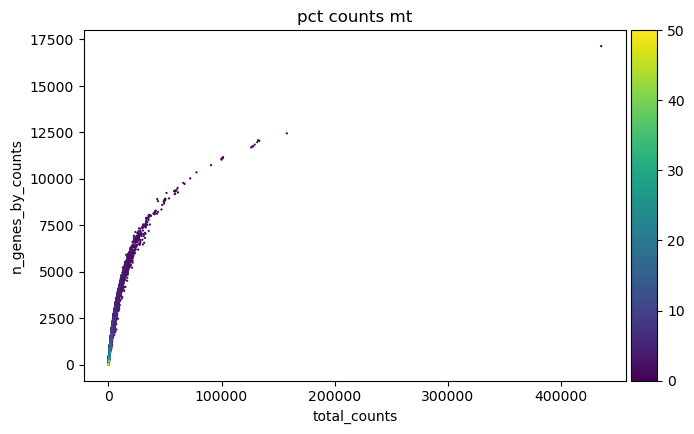

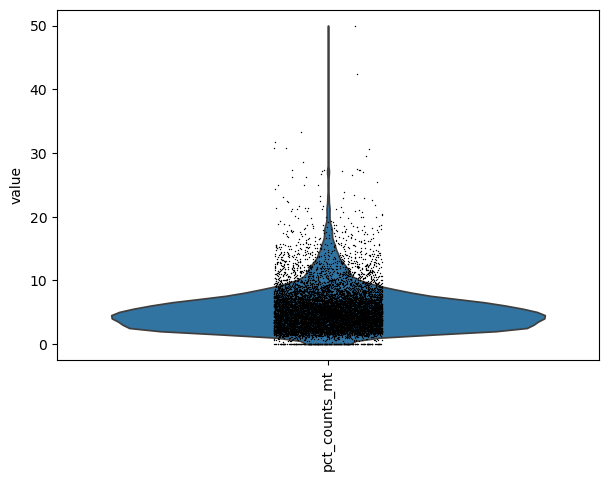

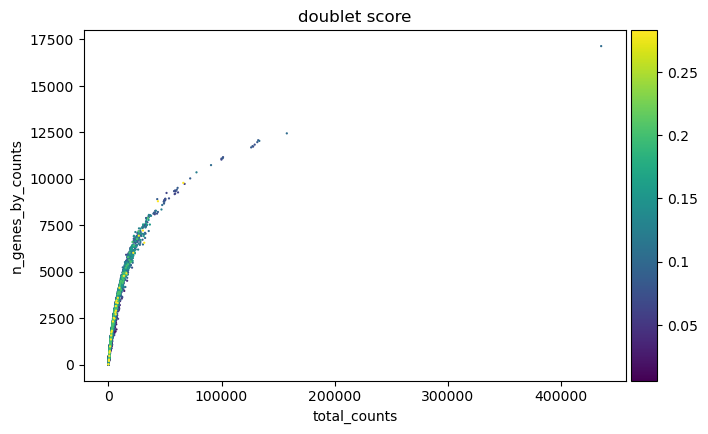

In [8]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")
sc.pl.violin(adata, "pct_counts_mt", rotation=90)
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="doublet_score")

# Heatmaps

In [11]:
adata.obs.columns.to_list()

['sample',
 'is_rr',
 'barcode',
 'well_position',
 'well_row',
 'well_column',
 'cell_type',
 'n_genes_by_counts',
 'log1p_n_genes_by_counts',
 'total_counts',
 'log1p_total_counts',
 'pct_counts_in_top_50_genes',
 'pct_counts_in_top_100_genes',
 'pct_counts_in_top_200_genes',
 'pct_counts_in_top_500_genes',
 'total_counts_mt',
 'log1p_total_counts_mt',
 'pct_counts_mt',
 'n_genes',
 'doublet_score',
 'predicted_doublet']

In [12]:
metrics = ["n_genes_by_counts", "log1p_n_genes_by_counts", "log1p_total_counts", "total_counts", "pct_counts_mt", "doublet_score"]
outdir = "figures"
os.makedirs(outdir, exist_ok=True)

for sample, metric in product(adata.obs["sample"].unique(), metrics):
    metric_dir = f"{outdir}/{metric}"
    os.makedirs(metric_dir, exist_ok=True)

    sample_data = adata[adata.obs["sample"] == sample, :].copy() #collect the data only for 1 sample
    heatmap_data = sample_data.obs.pivot_table(
        index='well_row',
        columns='well_column',
        values=metric
        )
    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_data, cmap='viridis', annot=False, fmt=".1f", cbar_kws={'label': metric})
    plt.title(sample)
    plt.xlabel("Well Column")
    plt.ylabel("Well Row")
    plt.tight_layout()
    
    plt.savefig(f"{metric_dir}/{sample}.png")
    plt.close()

100%|██████████| 180/180 [01:00<00:00,  2.95it/s]


# Venn diagram

In [95]:
sample_matching = pd.read_csv(
    "../data/reference/sample_matching.tsv",
    sep="\t",
    header=None
)
sample_matching.columns = ["rr_depleted", "rr_included", "facs_day"]
sample_matching.reset_index(inplace=True)
sample_matching.rename(columns={"index": "sample_group"}, inplace=True)
sample_matching = sample_matching.melt(value_vars=["rr_depleted", "rr_included"], id_vars=["sample_group", "facs_day"])
sample_matching.index = sample_matching["value"]
sample_matching.drop(columns=["value", "variable"], inplace=True)

sample_group = sample_matching["sample_group"].to_dict()
sample_facs_day = sample_matching["facs_day"].map({1: "A", 2: "B"}).to_dict()

In [38]:
#venn2([set(adata.obs.index[(adata.obs["is_rr"] == True) & (adata.obs["predicted_doublet"] == 1)]),
#        set(adata.obs.index[(adata.obs["is_rr"] == False) & (adata.obs["predicted_doublet"] == 1)])], ('is_rr == True', 'is_rr == False'))

In [99]:
sample_matching

,sample_group,facs_day
value,,
2CLCmesc_1,0,2
2CLCmesc_2,1,2
2CLCmesc_3,2,2
2CLCmesc_4,3,2
2CLCmesc_5,4,2
2CLCmesc_6,5,2
2CLCmesc_0-0-3,6,1
2CLCmesc_0-0-4,7,1
24L007781,8,1


In [101]:
adata.obs

,sample,is_rr,barcode,well_position,well_row,well_column,cell_type,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,...,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,n_genes,doublet_score,predicted_doublet
AAACAGGC_2CLCmesc_004_RR_S4_raw,2CLCmesc_004_RR_S4,True,AAACAGGC,H18,H,18,mESC,1839,7.517521,2876,...,16.098748,22.531293,32.788595,53.442281,128,4.859812,4.450626,1839,0.155556,False
AAAGCGGA_2CLCmesc_004_RR_S4_raw,2CLCmesc_004_RR_S4,True,AAAGCGGA,P12,P,12,mESC,1180,7.074117,1789,...,23.979877,31.414198,42.593628,61.989939,147,4.997212,8.216881,1180,0.102362,False
AAAGGCTG_2CLCmesc_004_RR_S4_raw,2CLCmesc_004_RR_S4,True,AAAGGCTG,O10,O,10,2CLC,711,6.568078,1053,...,28.584995,39.126306,51.471985,79.962013,66,4.204693,6.267806,711,0.102362,False
AACACGCA_2CLCmesc_004_RR_S4_raw,2CLCmesc_004_RR_S4,True,AACACGCA,L20,L,20,mESC,936,6.842683,1388,...,26.152738,34.365994,46.974063,68.587896,112,4.727388,8.069164,936,0.073171,False
AACATGGG_2CLCmesc_004_RR_S4_raw,2CLCmesc_004_RR_S4,True,AACATGGG,P10,P,10,2CLC,515,6.246107,775,...,37.161290,46.451613,59.354839,98.064516,56,4.043051,7.225806,515,0.073171,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGCAACC_2CLCmesc_2_RR_S10_raw,2CLCmesc_2_RR_S10,True,TTGCAACC,E18,E,18,mESC,510,6.236370,800,...,41.625000,48.750000,61.250000,98.750000,67,4.219508,8.375000,510,0.047836,False
TTGTTCCG_2CLCmesc_2_RR_S10_raw,2CLCmesc_2_RR_S10,True,TTGTTCCG,F19,F,19,mESC,637,6.458338,994,...,37.122736,45.975855,56.036217,86.217304,58,4.077537,5.835010,637,0.085911,False
TTTGAGGG_2CLCmesc_2_RR_S10_raw,2CLCmesc_2_RR_S10,True,TTTGAGGG,H17,H,17,mESC,756,6.629363,1131,...,32.360743,41.202476,50.839965,77.365164,79,4.382027,6.984969,756,0.102362,False
TTTGTGTC_2CLCmesc_2_RR_S10_raw,2CLCmesc_2_RR_S10,True,TTTGTGTC,D7,D,7,2CLC,320,5.771441,592,...,54.391892,62.837838,79.729730,100.000000,67,4.219508,11.317568,320,0.155556,False


## Filtering

Thresholds were estimated based on the raw QC plots.
Can be adjusted if needed.

In [39]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)
adata = adata[adata.obs["pct_counts_mt"] < 12, :].copy()
adata

AnnData object with n_obs × n_vars = 9535 × 27521
    obs: 'sample', 'is_rr', 'barcode', 'well_position', 'well_row', 'well_column', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'feature_types', 'gene_symbol', 'gene_versions', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'scrublet'
    layers: 'ambiguous', 'count', 'spliced', 'unspliced'

In [40]:
#filtering of ribo RNA and RNA with different thresholds
adata = adata[(adata.obs["is_rr"] == False) & (adata.obs["n_genes_by_counts"] > 100) & (adata.obs["pct_counts_mt"] < 12) | 
              (adata.obs["is_rr"] == True) & (adata.obs["n_genes_by_counts"] > 50) & (adata.obs["pct_counts_mt"] < 15), :].copy()
sc.pp.filter_genes(adata, min_cells=3)

## Filtered QC plots

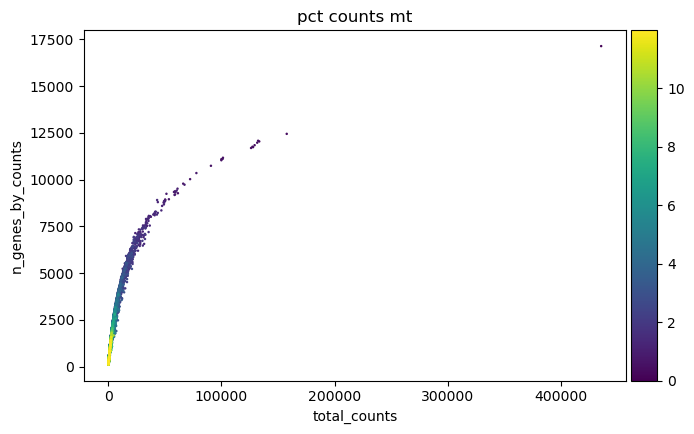

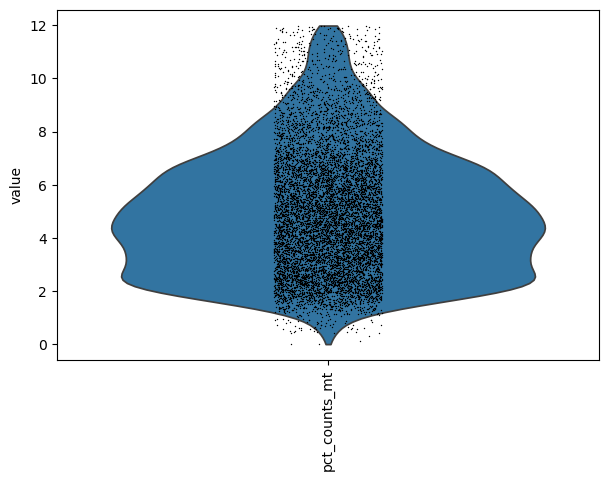

In [41]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")
sc.pl.violin(adata, "pct_counts_mt", rotation=90)

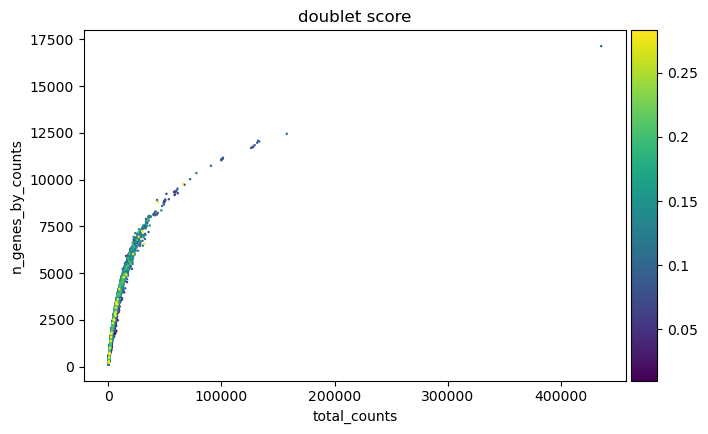

In [42]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="doublet_score")

In [43]:
adata = adata[~adata.obs["predicted_doublet"], :].copy()

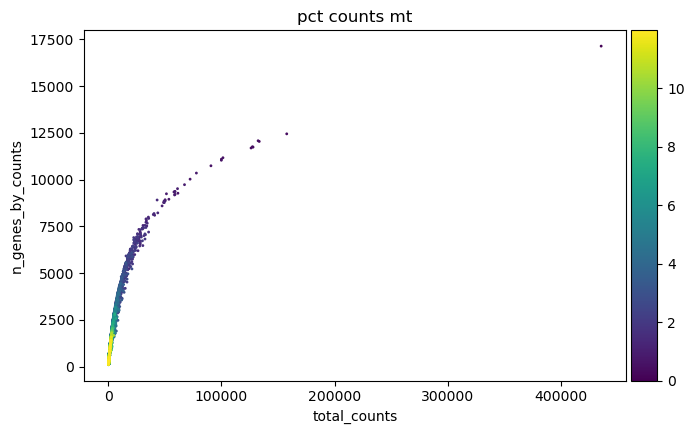

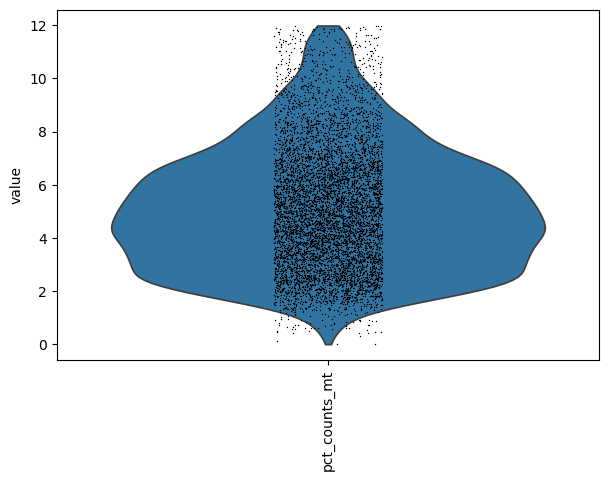

In [44]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")
sc.pl.violin(adata, "pct_counts_mt", rotation=90)

# Normalization

These steps update adata.X

In [45]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

# Finalize and save

In [46]:
# Make a copy of the log-transformed data
# It is always good to store alternative representations of count data with explicit names
# It is easy to forget what adata.X contains at a later point
adata.layers["log1p"] = adata.X.copy()
adata

AnnData object with n_obs × n_vars = 7351 × 27451
    obs: 'sample', 'is_rr', 'barcode', 'well_position', 'well_row', 'well_column', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'feature_types', 'gene_symbol', 'gene_versions', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'scrublet', 'log1p'
    layers: 'ambiguous', 'count', 'spliced', 'unspliced', 'log1p'

In [47]:
adata.write_h5ad("1_qc.h5ad")